In [25]:
# TODO: Data Loader module see 
# https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from dataset import MidiDataset
import mido
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [27]:
BUNDLE_SEPARATOR = 128
EOS = 129

In [28]:
# Bundle all note events together based on their time offset from each other
# Returns an array with dimensions (tracks, bundles per track)
def bundle_events(track : mido.MidiTrack):
    bundle = []
    bundles = []
    for msg in track:
        attrs = msg.dict()
        type = attrs["type"]
            
        if type == 'note_on' or type == 'note_off':
            if attrs['time'] == 0 or len(bundle) == 0:
                bundle.append(attrs)
            else:
                # Ensure that the first entry in the list has the time stamp info
                delta = bundle[0]['time']
                # Sort each entry in each bundle based on the note (in ascending order) 
                sorted_bundle = sorted(bundle, key=lambda x: int(x['note']))

                # Set all bundle entries to have time = 0 except for the first entry
                for b in sorted_bundle:
                    b['time'] = 0
                sorted_bundle[0]['time'] = delta 

                bundles.append(sorted_bundle)

                bundle.clear()
                bundle.append(attrs)

    return bundles

In [29]:
# Augment track bundles by removing note off / velocity = 0 events. 
def augment_track_bundles(track, verbose):
    aug = [[] for i in range(0, len(track))]
    time = 0

    # entries are of the form
    # note_id : {event, time_started, idx }
    state = {}

    # INitialize state 
    for i in range(0, 128): 
        state[i] = None

    for i, bundle in enumerate(track): 
        time += bundle[0]['time']
        for event in bundle: 
            if event['type'] == 'note_off' or event['velocity'] == 0:
                info = state[event['note']]

                if info == None: 
                    if verbose:
                        print("Poorly formatted key. Skipping")
                    continue 
                
                info['event']['duration'] = time - info['time']
                info['event']['time'] = info['time']

                if 'type' in info['event'].keys():
                    del info['event']['type']

                aug[info['idx']].append(info['event']) 
            else: 
                state[event['note']] = {'event': event, 'time': time, 'idx': i}

    # Remove any empty entries
    augmented = filter(lambda x : len(x) != 0, aug)

    return augmented

In [30]:
# Convert bundles to a list of notes, durations and velocities. 
# Each bundle note and velocity is separated from each other.
# Each duration corresponds to the duration of the ntote
# Each time corresponds to how far apart things are spaced. 
# Each velocity is normalized to be between 0 and 1 (by dividing by 127)

def create_lists(track):    
    notes = []
    durations = []
    times = []
    velocities = []
    
    current_time = 0

    for b in track:
        time = b[0]['time'] - current_time
        for x in b: 
            notes.append(x['note'])
            durations.append(x['duration'])
            velocities.append(int(x['velocity']))

        notes.append(BUNDLE_SEPARATOR)
        durations.append(0)
        times.append(time)
        velocities.append(0)

        current_time = time

    notes.append(EOS)
    durations.append(0)
    times.append(0)
    velocities.append(0)

    return np.array(notes), np.array(durations), np.array(times), np.array(velocities)

In [31]:
def normalize_to_beats(track_arr, ticks_per_beat):
    return track_arr / ticks_per_beat

In [32]:
def process_midi(path, verbose = False):
    if verbose:
        print("\"", path, "\"")
        
    try: 
        midi_file = mido.MidiFile(path)
        print("Tracks: ", len(midi_file.tracks))
    except: 
        print("Skipping corrupted file...")
        return None 

    track_notes = []
    track_durations = []
    track_times = []
    track_velocities = []

    for i, track in enumerate(midi_file.tracks):
        track_bundles = bundle_events(track)
        augmented_bundles = augment_track_bundles(track_bundles, verbose=verbose)
        notes, durations, times, velocities = create_lists(augmented_bundles)

        durations = normalize_to_beats(durations, midi_file.ticks_per_beat)
        times = normalize_to_beats(times, midi_file.ticks_per_beat)
        
        track_notes.append(notes)
        track_durations.append(durations)
        track_times.append(times)
        track_velocities.append(velocities)

    return np.array(track_notes, dtype=object), \
        np.array(track_durations, dtype=object), \
        np.array(track_times, dtype=object), \
        np.array(track_velocities, dtype=object)

# Dataset Creation

In [33]:
def make_dataset(midis, verbose = False) -> pd.DataFrame:

    df = pd.DataFrame(columns=["notes", "durations", "times", "velocities"])

    for mid in midis:
        out = process_midi(mid, verbose)
        if out is None: 
            continue 
        
        n, d, t, v  = out

        for i in range(0, len(n)):
            if (len(n[i]) > 1): # Do not include entries with no notes.
                df.loc[len(df.index)] = [n[i], d[i], t[i], v[i]]

    return df

In [34]:
# Extract all the midi files 

midi_files = []

for path, subdirs, files in os.walk(r'./data/'):
    for name in files:
        if (name.endswith('.mid')):
            midi_files.append(os.path.join(path, name))

In [35]:
TEST_FILE = r'Ode to Joy from the 9th Symphony.mid'
df = make_dataset(midi_files, verbose=True)
print(df)

" ./data/.38 Special\Caught Up In You.mid "
Tracks:  9
{'type': 'program_change', 'time': 0, 'program': 62, 'channel': 1}
{'type': 'program_change', 'time': 0, 'program': 87, 'channel': 2}
{'type': 'program_change', 'time': 0, 'program': 87, 'channel': 3}
{'type': 'program_change', 'time': 0, 'program': 25, 'channel': 4}
{'type': 'program_change', 'time': 0, 'program': 16, 'channel': 9}
" ./data/.38 Special\Fantasy Girl.mid "
Tracks:  7
{'type': 'program_change', 'time': 0, 'program': 29, 'channel': 0}
{'type': 'program_change', 'time': 0, 'program': 103, 'channel': 1}
{'type': 'program_change', 'time': 0, 'program': 33, 'channel': 2}
{'type': 'program_change', 'time': 0, 'program': 30, 'channel': 3}
{'type': 'program_change', 'time': 0, 'program': 8, 'channel': 4}
{'type': 'program_change', 'time': 0, 'program': 0, 'channel': 9}
" ./data/10,000 Maniacs\A Campfire Song.mid "
Tracks:  8
{'type': 'program_change', 'time': 0, 'program': 16, 'channel': 1}
{'type': 'program_change', 'time':

{'type': 'program_change', 'time': 96, 'program': 29, 'channel': 5}
{'type': 'program_change', 'time': 96, 'program': 105, 'channel': 6}
{'type': 'program_change', 'time': 96, 'program': 48, 'channel': 7}
{'type': 'program_change', 'time': 96, 'program': 0, 'channel': 9}
" ./data/Antonello Venditti\Settembre.1.mid "
Tracks:  16
{'type': 'program_change', 'time': 5, 'program': 35, 'channel': 1}
{'type': 'program_change', 'time': 6, 'program': 65, 'channel': 2}
{'type': 'program_change', 'time': 6, 'program': 71, 'channel': 3}
{'type': 'program_change', 'time': 5, 'program': 102, 'channel': 4}
{'type': 'program_change', 'time': 6, 'program': 1, 'channel': 5}
{'type': 'program_change', 'time': 53, 'program': 50, 'channel': 6}
{'type': 'program_change', 'time': 53, 'program': 95, 'channel': 7}
{'type': 'program_change', 'time': 53, 'program': 84, 'channel': 8}
{'type': 'program_change', 'time': 43, 'program': 0, 'channel': 9}
{'type': 'program_change', 'time': 54, 'program': 27, 'channel':

In [ ]:
midi = MidiDataset(df, context_len = -1)

In [ ]:
df.to_csv("midi-dataset.csv")

In [38]:
note_bins = [0 for i in range(0, 200)]

for i in range(0, len(df['notes'])):
    for x in df['notes'][i]:
        note_bins[x] += 1

plt.hist([x for x in filter(lambda x : x >= 0 and x < 128, df['notes'][0])], bins=88)
plt.show()

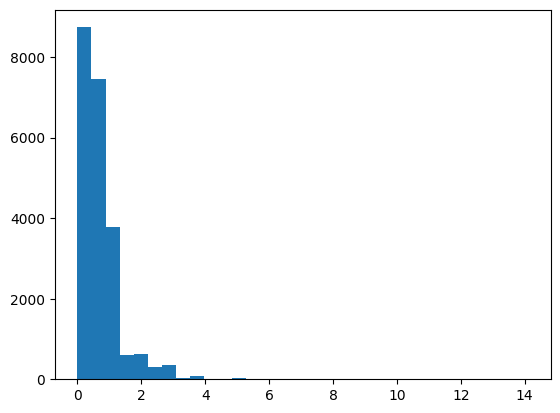

In [282]:
plt.hist(df['durations'][0], bins=32)
plt.show()

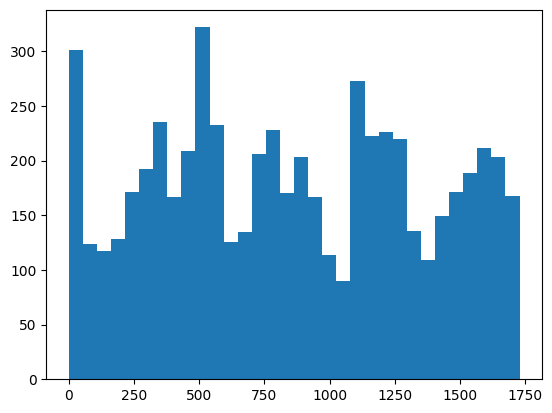

In [283]:
plt.hist(df['times'][0], bins=32)
plt.show()

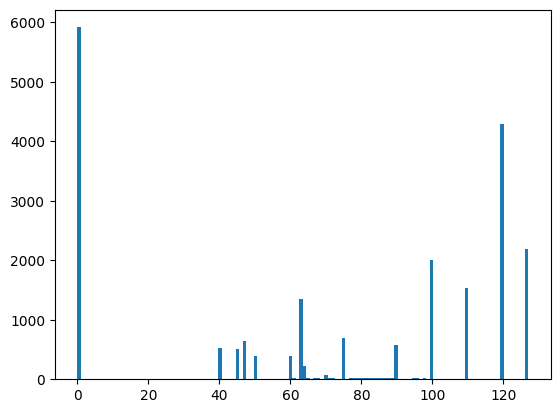

In [284]:
plt.hist(df['velocities'][0], bins=128)
plt.show()